In [3]:
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
from tqdm import tqdm, tnrange
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow.keras.backend as K
import pandas as pd
import re, random, pickle, glob, os, difflib, itertools
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from utils import *

In [2]:
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [6]:
bases=['A','T','G','C']
k3mers = [''.join(p) for p in itertools.product(bases, repeat=3)]
k6mers = [''.join(p) for p in itertools.product(bases, repeat=6)]

k3mers2 = [''.join(p) for p in itertools.product(['A','U','G','C'], repeat=3)]
k6mers2 = [''.join(p) for p in itertools.product(['A','U','G','C'], repeat=6)]
len(k3mers), len(k6mers)

(64, 4096)

In [17]:
train_size = 100000 #100k strings
X_train = []
X_train = create_X(X_train, k3mers2, k6mers2, train_size)
X_train = create_X(X_train, k3mers, k6mers, train_size)
X_train = np.array(X_train)
train_reads = np.expand_dims(np.array(seqs2onehot(X_train)), -1)

test_size = 1000
X_test = []
X_test = create_X(X_test, k3mers, k6mers, test_size)
X_test = create_X(X_test, k3mers2, k6mers2, test_size)
X_test = np.array(X_test)
test_reads = np.expand_dims(np.array(seqs2onehot(X_test)), -1)

advr_size = 2000
advr_reads = []
for num in range(advr_size):
    str_builder = ''
    random_indices = random.sample(range(len(k6mers)), 96)
    for i in range(96):
        str_builder += k6mers[random_indices[i]]
    advr_reads.append(str_builder)
advr_reads = np.array(advr_reads)
advr_samples = np.expand_dims(np.array(seqs2onehot(advr_reads)), -1)

In [19]:
train_reads.shape, test_reads.shape, advr_samples.shape

((200000, 576, 5, 1), (2000, 576, 5, 1), (2000, 576, 5, 1))

In [10]:
dim1 = train_reads.shape[1]; dim2 = train_reads.shape[2]

In [52]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        output = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return output

In [53]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= dim1 * dim2
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    def call(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [54]:
latent_dim = 2
width = 1
input_size = train_reads[0].shape
filter_size = (3, dim2)
epochs = 500

latent dim:  1 num filters:  1
ATGC acc  0.6484375
AUGC acc  0.640625


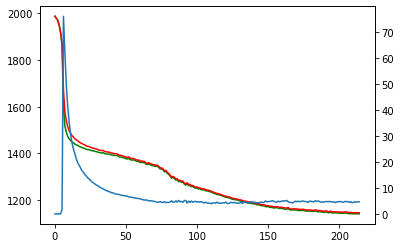

latent dim:  1 num filters:  2
ATGC acc  0.96875
AUGC acc  1.0


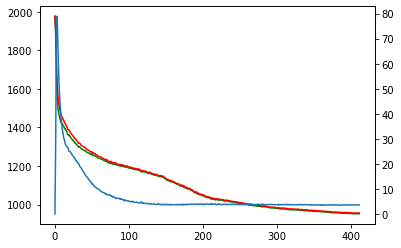

latent dim:  2 num filters:  1
ATGC acc  0.546875
AUGC acc  0.578125


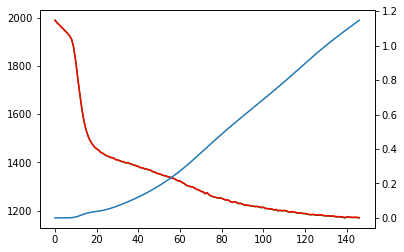

latent dim:  2 num filters:  2
ATGC acc  0.6875
AUGC acc  0.609375


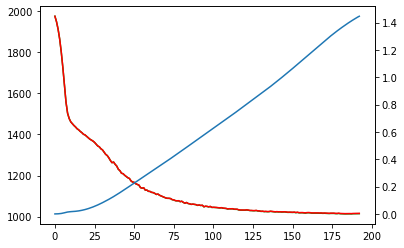

latent dim:  4 num filters:  1
ATGC acc  0.59375
AUGC acc  0.640625


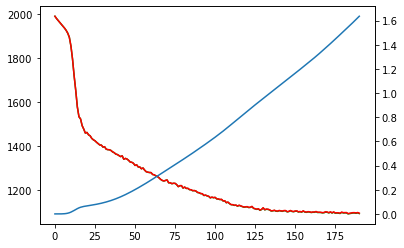

latent dim:  4 num filters:  2
ATGC acc  1.0
AUGC acc  1.0


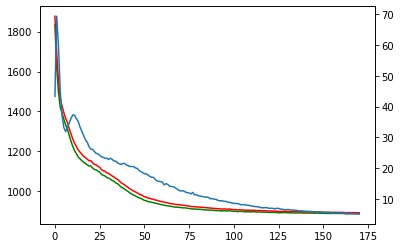

latent dim:  6 num filters:  1
ATGC acc  0.65625
AUGC acc  0.53125


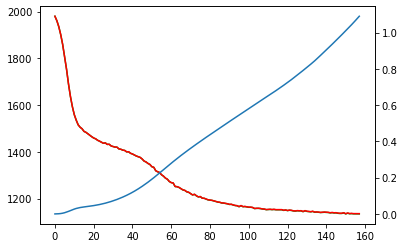

latent dim:  6 num filters:  2
ATGC acc  0.828125
AUGC acc  0.5


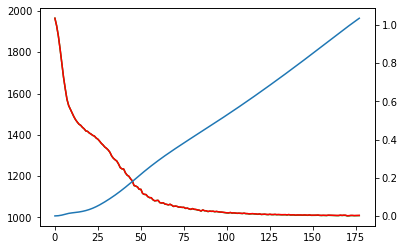

In [55]:
with strategy.scope():
    for latent_dim in [1,2,4,6]:
        for width in [1,2]:
            print("latent dim: ", latent_dim, "num filters: ", width)
            encoder_inputs = keras.Input(shape=input_size)
            x = layers.Conv2D(width, filter_size, activation="relu", strides=(2,1), padding="same")(encoder_inputs)
            x = layers.Flatten()(x)
            x = layers.Dense(width, activation="relu")(x)
            z_mean = layers.Dense(latent_dim, name="z_mean")(x)
            z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
            z = Sampling()([z_mean, z_log_var])
            encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
#             print(encoder.summary())

            latent_inputs = keras.Input(shape=(latent_dim,))
            x = layers.Dense(288 * dim2 * width, activation="relu")(latent_inputs)
            x = layers.Reshape((288, dim2, width))(x)
            x = layers.Conv2DTranspose(width, filter_size, activation="relu", strides=(2, 1), padding="same")(x)
            decoder_outputs = layers.Conv2D(1, filter_size, activation="sigmoid", padding="same")(x)

            decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
#             print(decoder.summary())

            vae = VAE(encoder, decoder)
            vae.compile(optimizer=keras.optimizers.Adam(0.0001))#, run_eagerly=True)
            history = vae.fit(train_reads, epochs=epochs, batch_size=2048, verbose=0,
                                callbacks = [EarlyStopping(monitor='loss', patience=7)])
            test_pred = vae.predict(test_reads)
            print("ATGC acc ", comp_acc(test_pred[:100], k3mers))
            print("AUGC acc ", comp_acc(test_pred[100:], k3mers2))
            fig, ax1 = plt.subplots()
            ax1.plot(history.history['reconstruction_loss'], color='green')
            ax1.plot(history.history['loss'], color='red')
            ax2 = ax1.twinx()
            ax2.plot(history.history['kl_loss'])
            plt.show()

In [4]:
vae = load_model('ld4_nf2')

## Filters

argmax for each row: [3 2 2]


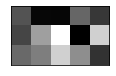

argmax for each row: [2 3 3]


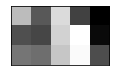

ACGT


In [61]:
filters, biases = vae.encoder.layers[1].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = width, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        print("argmax for each row:", np.argmax(f[:, :, j], 1))
        plt.imshow(f[:, :, j], cmap='gray')
        plt.show()
ix += 1
print("ACGT")
plt.show()

## Test results

In [63]:
test_pred = vae.predict(test_reads)
print("Are the reconstructions the same?", onehotdecode(test_pred[1]) == onehotdecode(test_pred[0]))
print("Edit distance: ", editDistDP(onehotdecode(test_pred[1]), onehotdecode(test_pred[0]), 576, 576))
print("Edit distance: ", editDistDP(onehotdecode(test_pred[1]), onehotdecode(test_pred[2]), 576, 576))
print("Edit distance: ", editDistDP(onehotdecode(test_pred[-1]), onehotdecode(test_pred[-23]), 576, 576))

Are the reconstructions the same? False
Edit distance:  57
Edit distance:  112
Edit distance:  45


## Adversarial results

In [20]:
advr_pred = vae.predict(advr_samples)

In [66]:
# Print number of 3-mers from (ATCG) there were not conserved
mis = []
for i in [onehotdecode(i) for i in advr_pred]:
    acc = 0
    for idx, k in enumerate(k3mers):
        temp = i[idx*9:idx*9+3]
        acc += temp == k
        if((temp==k)==False):
            mis.append(temp)
print("Incorrectly predicted 3mers: ", set(mis))
print("Input sequence A: \n", onehotdecode(advr_samples[0]), '\n')
print("Reconstruction of A: \n", onehotdecode(advr_pred[0]), '\n')
print("Reconstruction of B: \n", onehotdecode(advr_pred[1]), '\n')

Incorrectly predicted 3mers:  {'GAU', 'TAU', 'CAU', 'UTG', 'UUC', 'TUC', 'UCT', 'CCC', 'CUT', 'AGU', 'GGA'}
Input sequence A: 
 CCGGGGAGCTCGATGTCTTACCTATGAGGCACGGGGCGAGCCTGGCCAGTACCCGGAAAAGACCACATTGGATTCGCATCGGTCGGACTGTATGAAGGAGACTATAGGCACATAGACCGGCCCTGGACACGTTAAGCAGTTTTGGATAATTGGCTCTTTATCGGCTTATCAGAGGAGCGCACCCACGCAGCCGCCAGTGGGGCTGCAATAAACTGCAGCGCTTGACCGCCGTCGCACACGGGTAGCCTATAGCTTTCCCCCCACGGACGAGCCATACGACCTCTGAGATAATTAGAAAGCTGATCTTCCCACACCCGAGTCAGCAACGGCATACTTATTGATTTGCTTAACGTAACGTCAGCGACTCACATGTTTTGGTTTAGTACTCGGGTGCACGTCGGGCTTCTGAGCGAGCTAGTATTCCTCGAGCTTCCCGTGCATGCCAGCATTAAACACATGCACTTCCGCAGACAACCTTTTCCTCCTCAGCTGGAGTTTTTTTGCAATGCACATGGGTTTTGAGAATTGAAGGCCTATAGAGTTGGGAAAGAGCGCTTAGGTTTCAGTCGTCTATTT 

Reconstruction of A: 
 AAAACCGACAATGCCCCCAAGAACCGCAACCAACCGATAGCCGGAATTGACCCCATGCCACGAATCGGCCCAAGAAAAGACAGUCGCAGGAGGCCCGAAAGCCCCAAAACAACCAACACTAGCCCTACGCCGCGAACCCCAGAATAACAGCGGTAUGCGAAATAGGCCCACTACAAACAATTAGCCGGGTTTGCGAACUTGCCGCGAUUCGGCGGGGGACACACATGTACACCGTGGGCAAAATGCGAACACTCAACCCCTUCTGAGCAC

## Plots

### negative ELBO distribution

In [54]:
z_mean, z_log_var, pos_z = vae.encoder.predict(test_reads)
reconstruction = vae.decoder.predict(pos_z)
reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(test_reads, reconstruction), [1,2])
# reconstruction_loss *= dim1 * dim2
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss, [1])
kl_loss *= -0.5
pos_samples = (np.array(reconstruction_loss + kl_loss), np.array(reconstruction_loss), np.array(kl_loss))

z_mean, z_log_var, neg_z = vae.encoder.predict(advr_samples)
reconstruction = vae.decoder.predict(neg_z)
reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(advr_samples, reconstruction), [1,2])
# reconstruction_loss *= dim1 * dim2
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss, [1])
kl_loss *= -0.5
neg_samples = (np.array(reconstruction_loss + kl_loss), np.array(reconstruction_loss), np.array(kl_loss))

Positive samples


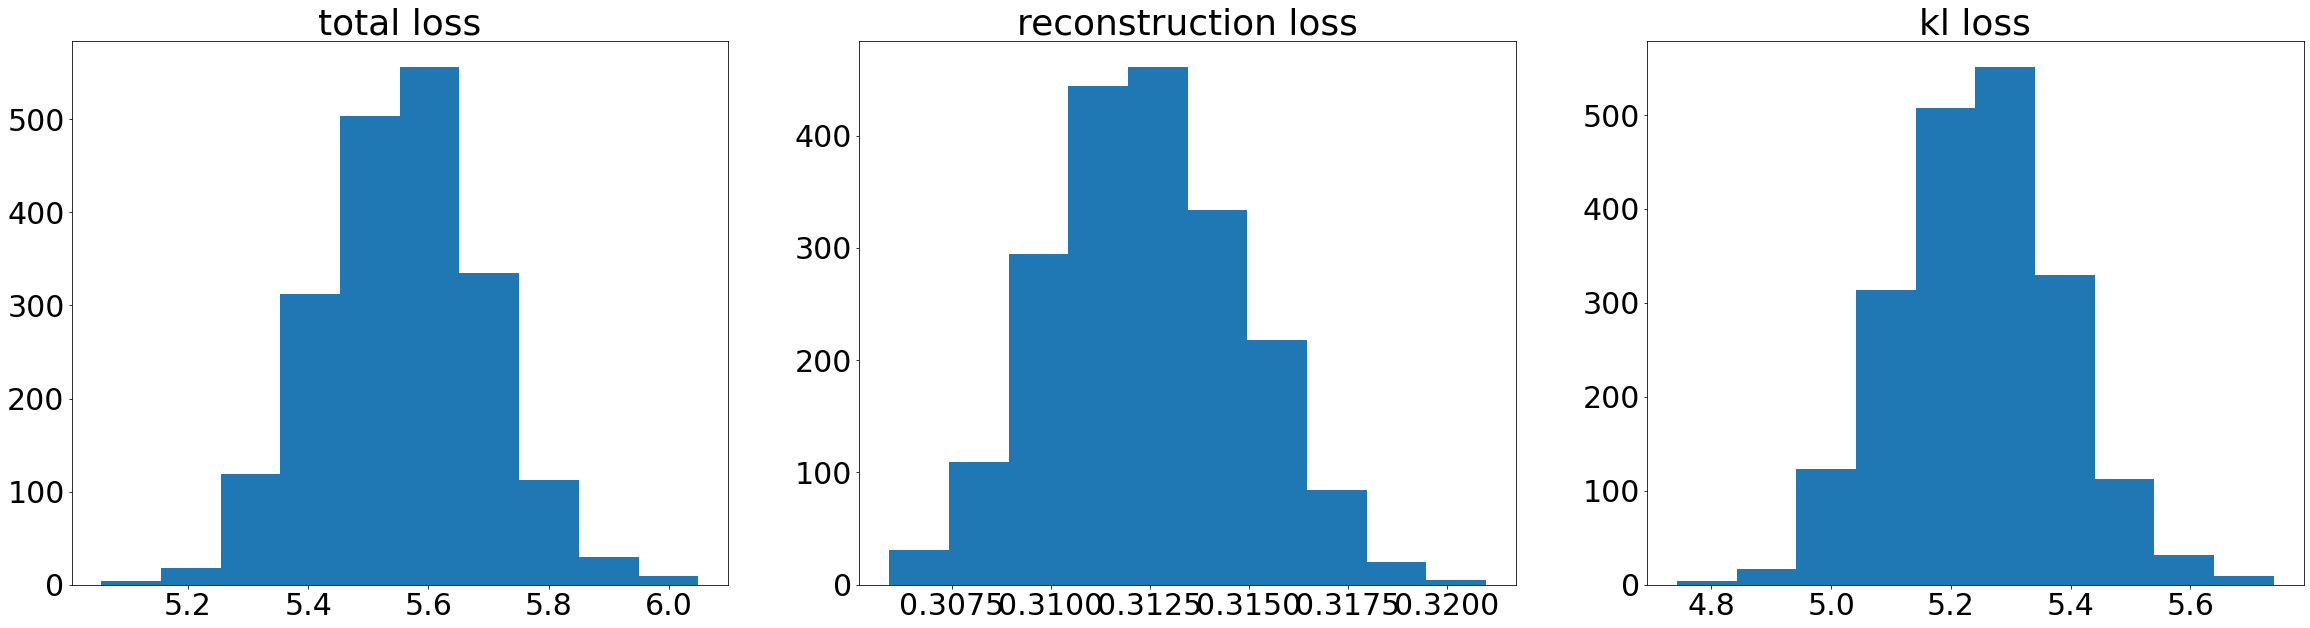

Negative samples


Text(0.5, 1.0, 'kl loss')

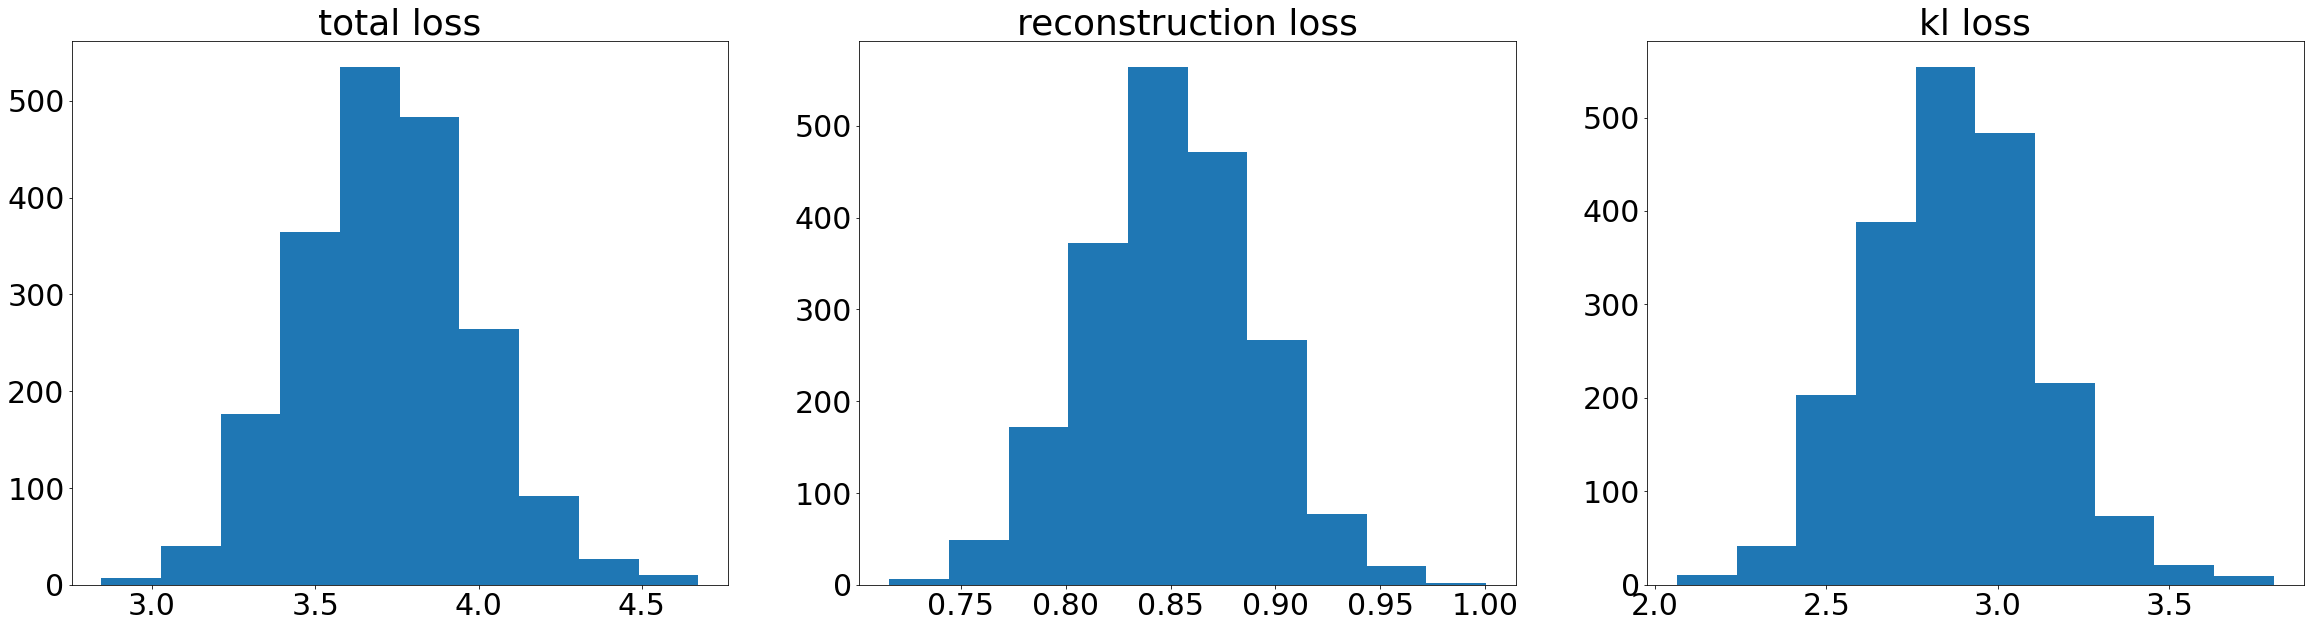

In [55]:
print('Positive samples')
plt.rcParams["font.size"] = "30"
fig, ax = plt.subplots(1,3, figsize=(40,10))
n, bins, patches = ax[0].hist(pos_samples[0]); ax[0].set_title('total loss')
n, bins, patches = ax[1].hist(pos_samples[1]); ax[1].set_title('reconstruction loss')
n, bins, patches = ax[2].hist(pos_samples[2]); ax[2].set_title('kl loss')
plt.show()
print('Negative samples')
fig, ax = plt.subplots(1,3, figsize=(40,10))
n, bins, patches = ax[0].hist(neg_samples[0]); ax[0].set_title('total loss')
n, bins, patches = ax[1].hist(neg_samples[1]); ax[1].set_title('reconstruction loss')
n, bins, patches = ax[2].hist(neg_samples[2]); ax[2].set_title('kl loss')

### latent distributions

Positive samples
Negative samples


<AxesSubplot:ylabel='Density'>

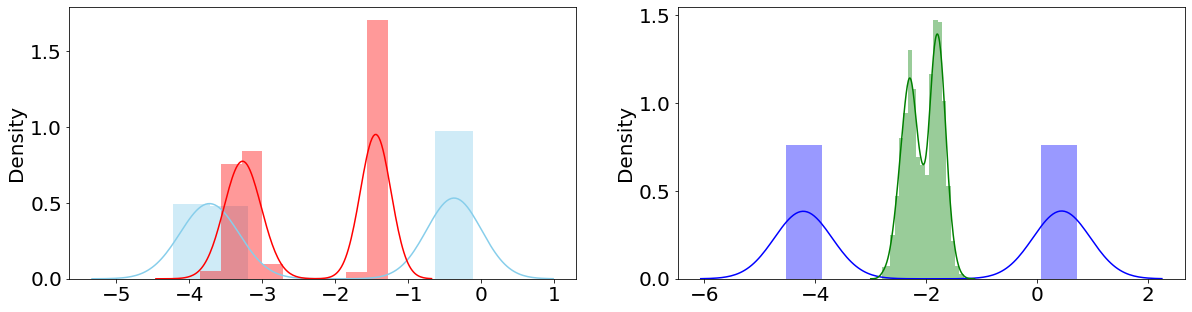

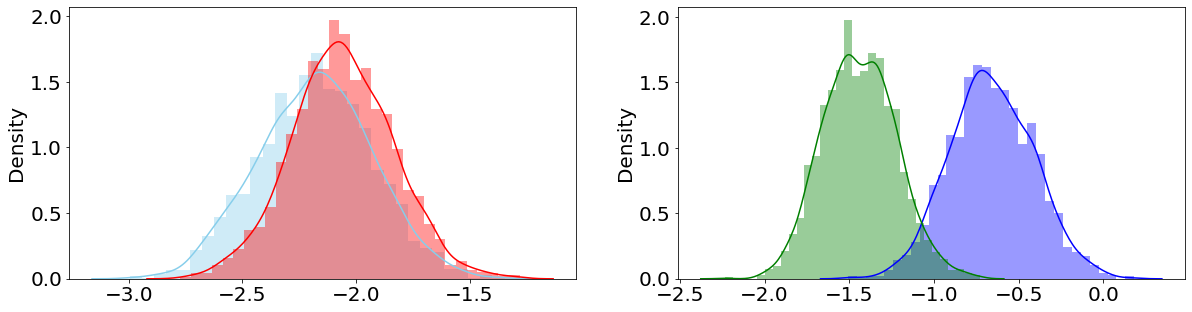

In [72]:
plt.rcParams["font.size"] = "20"
print("Positive samples")
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(np.array(pos_z)[:,0], color="skyblue", ax=ax[0])
sns.distplot(np.array(pos_z)[:,1], color="red", ax=ax[0])
sns.distplot(np.array(pos_z)[:,2], color="blue", ax=ax[1])
sns.distplot(np.array(pos_z)[:,3], color="green", ax=ax[1])

print("Negative samples")
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(np.array(neg_z)[:,0], color="skyblue", ax=ax[0])
sns.distplot(np.array(neg_z)[:,1], color="red", ax=ax[0])
sns.distplot(np.array(neg_z)[:,2], color="blue", ax=ax[1])
sns.distplot(np.array(neg_z)[:,3], color="green", ax=ax[1])